# [실습] 멀티 에이전트 구조

LangGraph의 Agent는 기본적으로 여러 개의 툴을 연결할 수 있습니다.   
그렇지만, 전체 구조를 하나의 에이전트로 구현하기보다는, 문제를 작게 나누는 Divide and Conquer 방식을 활용하여   
개별 문제를 해결하는 에이전트의 연결을 통해 답변하게 하는 것이 효과적일 수 있습니다.   

이는 Agent의 그래프를 따로 구성하고, Human-in-the-loop과 유사하게 `Command()`를 통해 전달하는 방식으로 이루어집니다.   

In [1]:
!pip install langgraph langchain langchain_google_genai langchain_community langchain_experimental langchain_tavily matplotlib seaborn

이번 실습은 한국어 시각화가 필요할 수 있으므로, 코랩에서는 아래 옵션을 실행합니다.

In [2]:
# Colab/Linux 환경에서 아래 옵션을 실행합니다.
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (18.9 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126718 files and direc

위 코드를 실행한 경우, 런타임 --> 세션 다시 시작을 수행해 주세요.

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [27]:
import os
os.environ['GOOGLE_API_KEY'] = 'AIxxx'
os.environ["TAVILY_API_KEY"] = "tvly-xxxx"

from langchain_core.rate_limiters import InMemoryRateLimiter
from langchain_google_genai import ChatGoogleGenerativeAI

# Gemini API는 분당 10개 요청으로 제한
# 즉, 초당 약 0.167개 요청 (10/60)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10개 요청
    check_every_n_seconds=0.1,  # 100ms마다 체크
    max_bucket_size=10,  # 최대 버스트 크기
)

# rate limiter를 LLM에 적용
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    rate_limiter=rate_limiter,
    temperature=0.2,
    max_tokens=8192
)

랭스미스 연동을 설정합니다.

In [ ]:
os.environ['LANGCHAIN_API_KEY'] = ''
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph_FastCampus'
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
os.environ['LANGCHAIN_TRACING_V2']='true'

## 1. Two Agents 협업 구조    


Tavily Tool과 Python Repl Tool을 이용합니다.

In [29]:
from langchain_tavily import TavilySearch
from langchain_core.tools import tool
import random
from io import StringIO
import sys
from contextlib import redirect_stdout


@tool
def tavily_search(query:str, max_results:int=5):
    """Tavily API를 통해 검색 결과를 가져옵니다.
query: 검색어
max_results : 검색 결과의 수(최소 1, 최대 20, 별도의 요청이 없으면 5로 고정)"""
    tavily_search = TavilySearch(max_results=max_results,
                                 include_raw_content = 'markdown'
    )

    search_results = tavily_search.invoke(query)

    context = f''
    for doc in search_results['results']:
        if doc.get('raw_content'):
            doc_content = doc.get('raw_content')[:3000]
        else:
            doc_content = doc.get('content')
        context += 'TITLE: ' + doc.get('title','N/A') + '\nURL:' + doc.get('url')+ '\nContent:'+ doc_content + '\n---\n'
    return context


def python_repl(code: str) -> str:
    # 코드 정리
    code = code.strip().strip('`')
    if code.startswith('python'):
        code = code[6:].strip()

    # stdout 캡처 (context manager 사용으로 안전하게)
    buffer = StringIO()

    try:
        # redirect_stdout을 사용하면 자동으로 복원됨
        with redirect_stdout(buffer):
            exec(code, globals())

        # 결과 가져오기
        output = buffer.getvalue()
        return output if output else "실행 완료"

    except Exception as e:
        return f"Error: {type(e).__name__}: {str(e)}"


In [30]:
from typing import Annotated


# 툴 정보를 보다 자세하게 작성하여 성능을 높입니다.
# LangGraph의 기본 표현을 사용했습니다!
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = python_repl(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return result_str

각각의 툴을 연결한 Agent를 만들겠습니다.   
System Prompt을 커스터마이징한 ReAct Agent를 구성합니다.   

최종 출력 조건을 프롬프트에 언급하여 커뮤니케이션의 중단을 표시합니다.


In [31]:
from langgraph.prebuilt import create_react_agent

def make_system_prompt(prefix: str) -> str:
    return f"""
[기본 지침]
{prefix}

당신은 여러 AI 어시스턴트와 협업하는 팀원입니다.
목표: 주어진 도구들을 반복적으로 활용해 사용자의 질문에 답하기
당신의 작업물은 다른 에이전트에게 전달되어 최종 답변으로 사용될 것입니다.

[작업 지침]
1. 완벽한 답변이 어렵다면 가능한 부분까지 진행하세요
2. 나머지는 다른 도구를 가진 팀원이 이어서 작업할 것입니다
3. 다른 팀원에게 넘겨주어야 하는 경우, GO! 를 마지막에 출력하세요.
4. 당신과 다른 팀원의 모든 작업이 완료된 경우 MISSION COMPLETED를 마지막에 출력하세요.

팀원이 문제를 잘 해결할 수 있도록, 중요한 부분만 명료하게 설명하세요.
툴을 실행한 후에, 결과를 바탕으로 다음 작업을 설명하세요.


"""

# Research Agent 프롬프트
research_agent = create_react_agent(llm, tools=[tavily_search],
    prompt=make_system_prompt(
        """당신의 이름은 Research 전문가 'Amy' 입니다.
[작업] 정보 검색 및 정리를 수행하세요.
[협업] Chart 생성 전문가 'Brad'와 함께 작업 중입니다."""
    ),
)

# Chart Agent 프롬프트
chart_agent = create_react_agent(llm, [python_repl_tool],
    prompt=make_system_prompt(
        """당신의 이름은 Chart 생성 전문가 'Brad' 입니다.
[작업] 파이썬 코드 실행 및 차트 생성을 수행하세요.
[협업] Research 전문가 'Amy' 와 함께 작업 중입니다.

한국어 시각화의 경우, 폰트는 NanumBarunGothic를 사용하세요."""
    ),
)

/tmp/ipython-input-2685819431.py:25: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(llm, tools=[tavily_search],
/tmp/ipython-input-2685819431.py:34: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_agent = create_react_agent(llm, [python_repl_tool],


In [32]:
# chart_agent.invoke(
#     {'messages':[HumanMessage('Amy입니다. 2024년 프로야구 최종 순위를 검색하여 데이터를 추출했습니다. 이 데이터를 기반으로 Brad에게 그래프 생성을 요청했습니다.\n\n**2024년 프로야구 최종 순위:**\n\n*   **KIA 타이거즈**: 승률 0.612\n*   **삼성 라이온즈**: 승률 0.549\n*   **LG 트윈스**: 승률 0.535\n*   **두산 베어스**: 승률 0.521\n*   **kt wiz**: 승률 0.507\n*   **SSG 랜더스**: 승률 0.507\n*   **롯데 자이언츠**: 승률 0.471\n*   **한화 이글스**: 승률 0.464\n*   **NC 다이노스**: 승률 0.429\n*   **키움 히어로즈**: 승률 0.403\n\nGo!')]}
# )

State를 구성합니다.

In [33]:
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages : Annotated[list, add_messages]

그래프를 만들고 구성합니다.  

`goto`를 통해, 종료할지/다음 에이전트로 Context를 전달할지를 결정합니다.   

`command`를 통해 다음 경로를 명시적으로 지정할 수 있습니다.   
(이는 Typing에 표시하면, 시각화 과정에 나타납니다.)

In [34]:
from typing import Literal
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage


# Next Node를 선택하는 과정: 노드로 구성하여 그래프에 표시
def get_next_node(last_message, goto: str):
    if "MISSION COMPLETED" in last_message.content:
        return END
    return goto



def research_node(state: State) -> Command[Literal["chart_generator", END]]:

    result = research_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "chart_generator")

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="researcher")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"][-1:]}, goto=goto)


def chart_node(state: State) -> Command[Literal["researcher", END]]:
    result = chart_agent.invoke(state)
    goto = get_next_node(result["messages"][-1], "researcher")

    print('== \n\n\n',result['messages'],'\n\n== \n\n\n')

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="chart_generator")

    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"][-1:]}, goto=goto)

상호작용 + ReAct Agent의 조합으로 전체 그래프를 구성합니다.

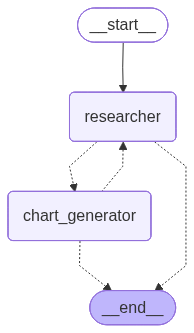

In [35]:
from langgraph.graph import StateGraph, START

builder = StateGraph(State)
builder.add_node("researcher", research_node)
builder.add_node("chart_generator", chart_node)

builder.add_edge(START, "researcher")
graph = builder.compile()

graph

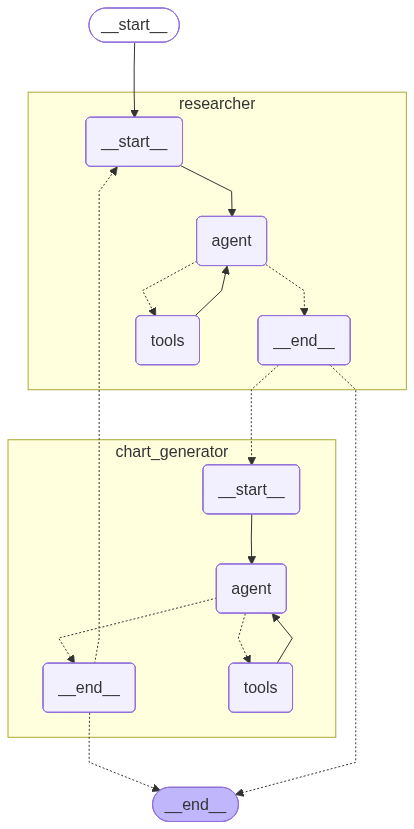

In [36]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

(('researcher:ce999e17-aec8-b1f8-80f0-76874f1e737e',), {'agent': {'messages': [AIMessage(content='2024년 프로야구 순위를 검색하겠습니다. 최대 20개의 결과를 요청합니다.', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "2024 \\ud504\\ub85c\\uc57c\\uad6c \\uc21c\\uc704", "max_results": 20}'
[중략]
22cb1fbf9-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '2024 프로야구 순위', 'max_results': 20}, 'id': 'ba693c74-a888-4c5a-89d6-b4ec50a32a85', 'type': 'tool_call'}], usage_metadata={'input_tokens': 372, 'output_tokens': 47, 'total_tokens': 419, 'input_token_details': {'cache_read': 0}})]}})

------------

(('researcher:ce999e17-aec8-b1f8-80f0-76874f1e737e',), {'tools': {'messages': [ToolMessage(content='TITLE: [KBO]2024년 프로야구 최종 순위(종합순위, 수비순위, 공격순위)\nURL:https://www.clien.net/service/board/park/18813486\nContent:[KBO]2024년 프로야구 최종 순위(종합순위, 수비순위, 공격순위) : 클리앙\n\n===============\n\n[CLIEN](https://www.c
[중략]
  [순\n---\nTITLE: 2025 시즌 팀 순위 - KT위즈파크\nURL:https://www.ktwiz.co.kr/gam

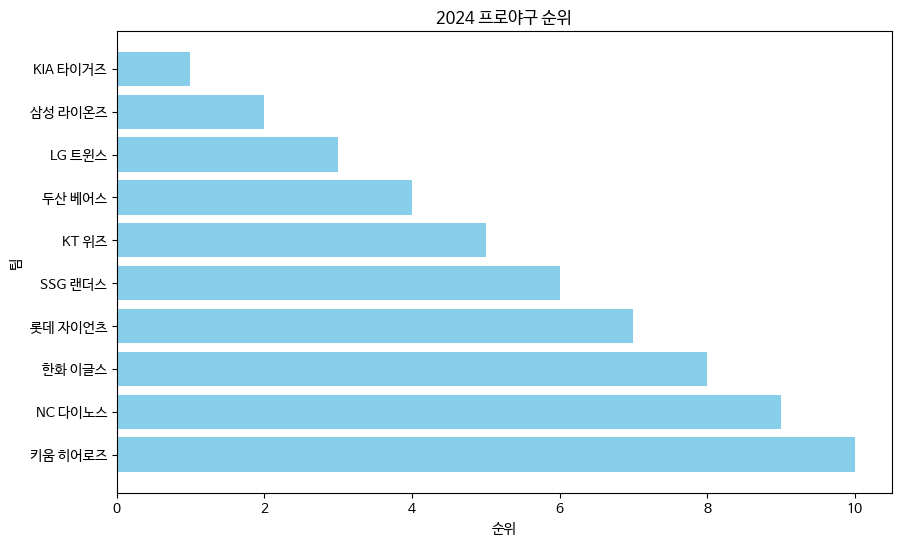

In [37]:
events = graph.stream(
    {
        "messages": [
            ("user","2024년 프로야구 순위를 검색해서 그래프로 시각화해줘. 결과는 rank.png에 저장해.")
        ],
    },
    {"recursion_limit": 150},
    subgraphs= True, stream_mode='updates'
)
for s in events:
    print(str(s)[:300])
    print('[중략]')
    print(str(s)[-300:])
    print('\n------------\n')

## 2. Supervisor

두 에이전트가 서로 소통하는 방식은 고정된 커뮤니케이션 경로로 구성됩니다.

하지만, 차트 에이전트의 코드만을 수정하고 싶거나, 리서치 에이전트의 결과를 바로 수정하고 싶은 경우는 해당 경로가 효과적이지 않은데요, Supervisor 구조를 통해 이를 해결해 보겠습니다.

경로 설정을 위해, agent 목록과 route 목록을 구성합니다.

In [38]:
agents = ["researcher", "chart_generator"]
routes = agents + ["FINISH"]

from pydantic import BaseModel, Field

class Router(BaseModel):
    reason : str = Field(description='dest를 선택한 이유를 30자 이내로 설명')
    send_msg : str = Field(description='해당 에이전트에 추가로 요청할 말(자연어 말투로)')
    dest: Literal[*routes] = Field(description="다음 작업을 수행할 에이전트를 결정합니다. 만약 모든 작업이 완료되었다면 FINISH를 출력합니다.")


프롬프트를 구성하고, 현재 상황을 판단해 적절한 에이전트를 선택하고 전달하도록 구성합니다.

In [54]:
system_prompt = f"""
당신은 작업 관리자입니다.
당신의 역할은 주어진 질의를 풀기 위해,

여러 에이전트 간의 대화를 관리하고 조율하는 것입니다.
관리해야 하는 에이전트들은 다음과 같습니다: [{agents}]

[작업 지침]
1. 사용자 요청에 대한 현재 진행 상황에 따라 다음 작업할 에이전트를 선택하세요
2. 각 에이전트는 자신의 작업 결과와 상태를 보고할 것입니다
3. 두 에이전트는 당신의 의견을 요청할 수 있습니다. 적절한 내용으로 답변하세요.
4. 모든 에이전트가 작업을 완료하여 문제가 해결된 경우, FINISH로 응답하세요. 작업이 남아 있는 경우에는 계속 다른 에이전트에게 피드백을 제공하세요.

[Notes]
모든 에이전트가 작업에 참여해야만 하는 것은 아닙니다.
작업이 완료된 경우, FINISH로 응답하세요.
"""

In [55]:
from typing_extensions import TypedDict
class State(TypedDict):
    dest : str
    messages : Annotated[list, add_messages]


In [56]:
def supervisor(state: State) -> Command[Literal[*agents, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    response = llm.with_structured_output(Router).invoke(messages)

    print('##SUPERVISOR: ', response.dest, '-->', response.reason)

    print("요청:", response.send_msg)

    goto = response.dest
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"dest": goto, 'messages':HumanMessage(response.send_msg)})

In [57]:
def make_system_prompt(suffix: str) -> str:
    return f"""
당신은 툴 사용 에이전트입니다.
아래의 정보를 바탕으로, 문제를 해결하기 위한 과정을 수행하세요.
당신의 영역 밖의 작업은, 다른 에이전트가 수행할 것입니다.
툴 사용이 끝나면, 반드시 상세하게 결과를 설명하세요.

{suffix}
"""

# Research Agent 프롬프트
research_agent = create_react_agent(llm, tools=[tavily_search],
    prompt=make_system_prompt(
        """당신의 이름은 Research 전문가 'Amy' 입니다.
[작업] 정보 검색 및 정리를 수행하세요.
[협업] Chart 생성 전문가 'Brad'와 함께 작업 중입니다."""
    ),
)

# Chart Agent 프롬프트
chart_agent = create_react_agent(llm, [python_repl_tool],
    prompt=make_system_prompt(
        """당신의 이름은 Chart 생성 전문가 'Brad' 입니다.
[작업] 파이썬 코드 실행 및 차트 생성을 수행하세요.
[협업] Research 전문가 'Amy' 와 함께 작업 중입니다."""
    ),
)


def researcher(state: State) -> Command[Literal["supervisor"]]:

    result = research_agent.invoke(state)

    print('## Researcher \n\n', result["messages"], '\n\n\n')

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="researcher")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"][-1:]}, goto='supervisor')


def chart_generator(state: State) -> Command[Literal["supervisor"]]:
    result = chart_agent.invoke(state)

    print('## Chart \n\n', result["messages"], '\n\n\n')

    result["messages"][-1] = HumanMessage(result["messages"][-1].content, name="chart_generator")
    # name은 실제로 역할이 없으나, 디버깅 및 확인을 위해 구성

    return Command(update={"messages": result["messages"][-1:]}, goto='supervisor')

/tmp/ipython-input-2514811527.py:12: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(llm, tools=[tavily_search],
/tmp/ipython-input-2514811527.py:21: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  chart_agent = create_react_agent(llm, [python_repl_tool],


In [58]:
builder = StateGraph(State)

builder.add_node("supervisor", supervisor)
builder.add_node("researcher", researcher)
builder.add_node("chart_generator", chart_generator)

builder.add_edge(START, "supervisor")

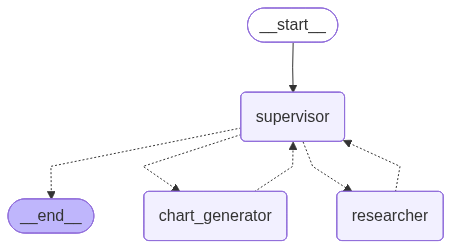

In [59]:
graph = builder.compile()
graph

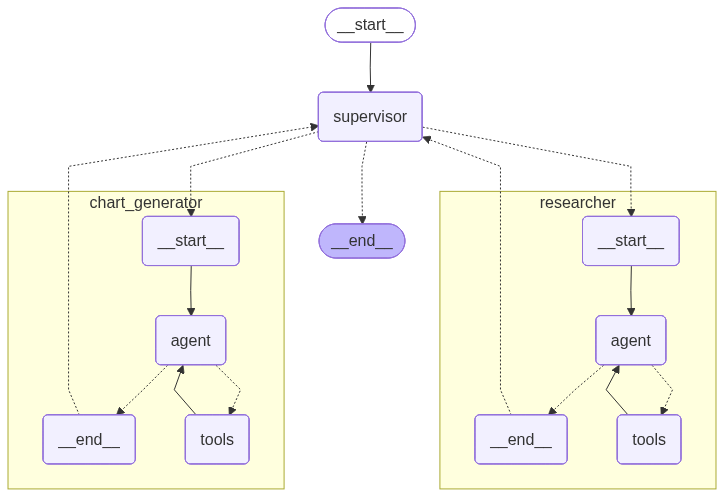

In [60]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

##SUPERVISOR:  researcher --> 도시별 최저 기온 조사를 위해 researcher에게 작업을 요청합니다.
요청: 2025년 10월 15일 기준, 한국 주요 도시 4곳의 최저 기온을 조사해줘. 오늘은 2025년 10월 26일이야.
((), {'supervisor': {'dest': 'researcher', 'messages': HumanMessage(content='2025년 10월 15일 기준, 한국 주요 도시 4곳의 최저 기온을 조사해줘. 오늘은 2025년 10월 26일이야.', additional_kwargs={}, response_metadata={})}})
[중략]
((), {'supervisor': {'dest': 'researcher', 'messages': HumanMessage(content='2025년 10월 15일 기준, 한국 주요 도시 4곳의 최저 기온을 조사해줘. 오늘은 2025년 10월 26일이야.', additional_kwargs={}, response_metadata={})}})

------------

(('researcher:3dfe47a8-7bfe-cda7-7b75-1687425197f9',), {'agent': {'messages': [AIMessage(content='알겠습니다. 2025년 10월 15일 기준 한국 주요 도시 4곳의 최저 기온을 조사하겠습니다. 어떤 도시를 조사할까요? 도시를 지정해주시면 해당 도시의 최저 기온을 검색하겠습니다. 만약 특정 도시를 지정하지 않으시면, 임의로 서울, 부산, 대구, 광주를 선택하여 검색하겠습니다.', additional_kwargs={}, response_metadata={'pr
[중략]
P', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--fe92479e-60a3-44d2-

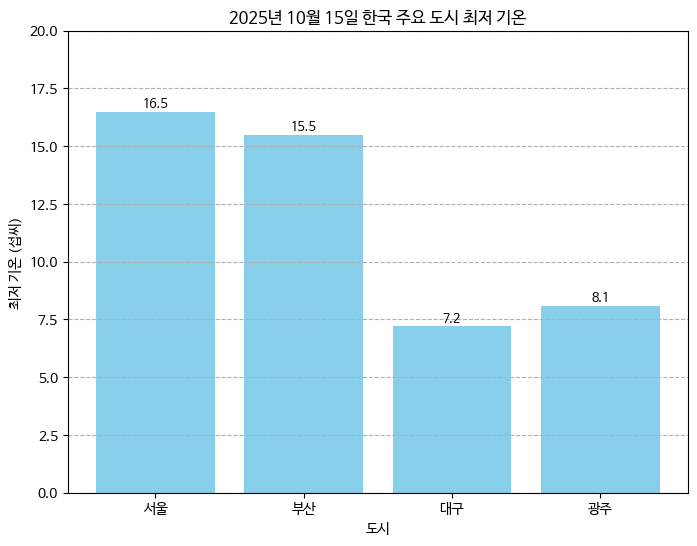

(('chart_generator:708f93ed-d9fc-097b-6c5e-88aa8e3c24cc',), {'agent': {'messages': [AIMessage(content='알겠습니다. 요청하신 대로 2025년 10월 15일 서울, 부산, 대구, 광주의 최저 기온을 막대 그래프로 만들어 드리겠습니다. 아래 Python 코드를 사용하여 차트를 생성하겠습니다.', additional_kwargs={'function_call': {'name': 'python_repl_tool', 'arguments': '{"code": "\\
[중략]
          horizontalalignment=\'center\',\n             verticalalignment=\'bottom\')\n\nplt.show()\n'}, 'id': '73ec7216-3851-450b-ba75-d8a943b522e1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 648, 'output_tokens': 320, 'total_tokens': 968, 'input_token_details': {'cache_read': 0}})]}})

------------

(('chart_generator:708f93ed-d9fc-097b-6c5e-88aa8e3c24cc',), {'tools': {'messages': [ToolMessage(content='Successfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\ncities = ["서울", "부산", "대구", "광주"]\ntemperatures = [16.5, 15.5, 7.2, 8.1]\n\nplt.figure(figsize=(8, 6))\nplt.bar(cities, tem
[중략]
  fontsize = 9, \n             color=\'black\',\n             horizontal

In [61]:
events = graph.stream(
    {
        'next':'',
        "messages": [
            ("user","오늘은 2025년 10월 26일이야. 2025년 10월 15일 기준, 한국 주요 도시를 4개 선정하고, 각 도시의 최저 기온을 조사해서 비교해줘.")
        ],
    },subgraphs=True,stream_mode='updates')

for s in events:
    print(str(s)[:300])
    print('[중략]')
    print(str(s)[-300:])
    print('\n------------\n')

In [63]:
events = graph.stream(
    {
        'next':'',
        "messages": [
            ("user","잠실역 맛집 3개 추천해줘. 시각화는 안 해도 돼.")
        ],
    },subgraphs=True,stream_mode='updates')


for s in events:
    print(str(s)[:300])
    print('[중략]')
    print(str(s)[-300:])
    print('\n------------\n')

##SUPERVISOR:  researcher --> 맛집 3곳 추천을 위해
요청: 잠실역 맛집 3곳 추천해줘
((), {'supervisor': {'dest': 'researcher', 'messages': HumanMessage(content='잠실역 맛집 3곳 추천해줘', additional_kwargs={}, response_metadata={})}})
[중략]
((), {'supervisor': {'dest': 'researcher', 'messages': HumanMessage(content='잠실역 맛집 3곳 추천해줘', additional_kwargs={}, response_metadata={})}})

------------

(('researcher:9cdd36d9-5fae-b05c-40d5-95d7088c664e',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "\\uc7a0\\uc2e4\\uc5ed \\ub9db\\uc9d1 \\ucd94\\ucc9c", "max_results": 3}'}}, response_metadata={'prompt_feedback'
[중략]
-b93625783c7e-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '잠실역 맛집 추천', 'max_results': 3}, 'id': 'a89f2663-ece9-421d-b934-a9d57164c762', 'type': 'tool_call'}], usage_metadata={'input_tokens': 226, 'output_tokens': 17, 'total_tokens': 243, 'input_token_details': {'cache_read': 0}})]}})

------------

(('researcher:

##SUPERVISOR:  researcher --> AI 툴 사용 설문조사 데이터 조사를 위해 researcher에게 작업을 요청
요청: 한국에서 진행된 AI 툴 사용 설문조사 데이터를 찾아줘
((), {'supervisor': {'dest': 'researcher', 'messages': HumanMessage(content='한국에서 진행된 AI 툴 사용 설문조사 데이터를 찾아줘', additional_kwargs={}, response_metadata={})}})
[중략]
((), {'supervisor': {'dest': 'researcher', 'messages': HumanMessage(content='한국에서 진행된 AI 툴 사용 설문조사 데이터를 찾아줘', additional_kwargs={}, response_metadata={})}})

------------

(('researcher:9dac308b-d46a-2d52-c131-22f56896b8ed',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search', 'arguments': '{"query": "\\ud55c\\uad6d AI \\ud234 \\uc0ac\\uc6a9 \\uc124\\ubb38\\uc870\\uc0ac", "max_results": 5}'}}, response_metadata=
[중략]
2ffb4a4-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': '한국 AI 툴 사용 설문조사', 'max_results': 5}, 'id': '1a3890cb-cda9-448a-83e4-262468f3efa8', 'type': 'tool_call'}], usage_metadata={'input_tokens': 236, 'output_tokens': 18, 'total_tokens': 25

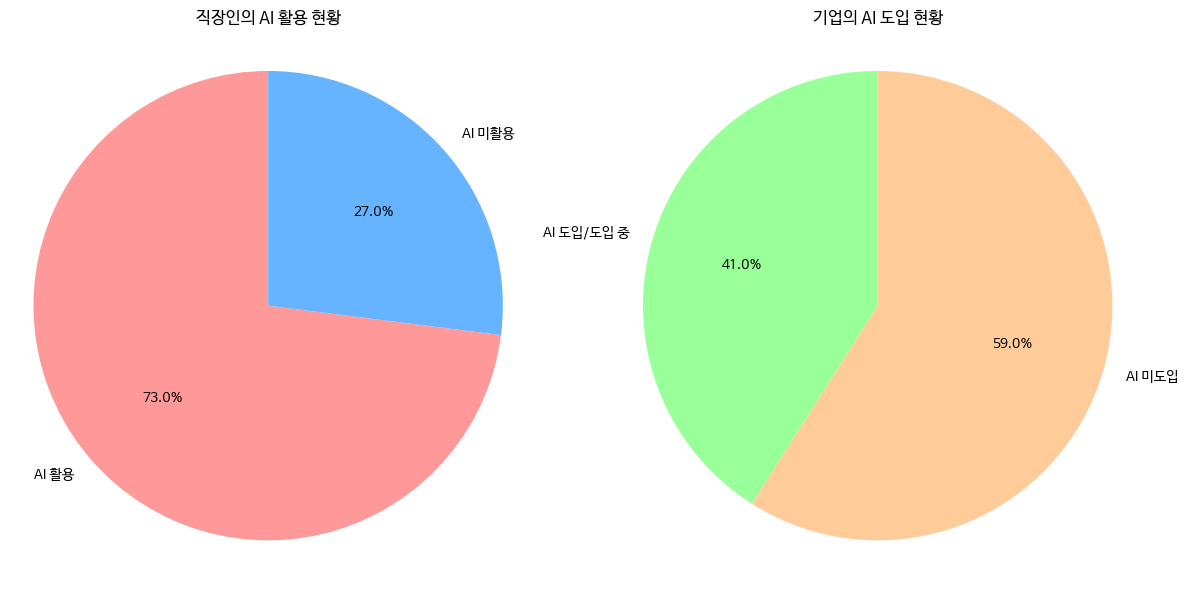

(('chart_generator:ded2a1c8-6511-79ff-afc3-a94cc27c61ef',), {'agent': {'messages': [AIMessage(content='', additional_kwargs={'function_call': {'name': 'python_repl_tool', 'arguments': '{"code": "\\nimport matplotlib.pyplot as plt\\n\\n# \\uc9c1\\uc7a5\\uc778\\uc758 AI \\ud65c\\uc6a9 \\ud604\\ud669\\
[중략]
tartangle=90)\nax2.axis('equal')\nax2.set_title('기업의 AI 도입 현황')\n\nplt.tight_layout()\nplt.show()\n"}, 'id': '7f120249-a2e9-4686-b0f4-9d85416d9432', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2226, 'output_tokens': 352, 'total_tokens': 2578, 'input_token_details': {'cache_read': 0}})]}})

------------

(('chart_generator:ded2a1c8-6511-79ff-afc3-a94cc27c61ef',), {'tools': {'messages': [ToolMessage(content="Successfully executed:\n```python\n\nimport matplotlib.pyplot as plt\n\n# 직장인의 AI 활용 현황\nemployee_labels = 'AI 활용', 'AI 미활용'\nemployee_sizes = [73, 27]\nemployee_colors = ['#ff9999', '#66b3ff']\n
[중략]
ny_labels, colors=company_colors, autopct='%1.1f%%', startangle=90)\nax2

In [64]:
events = graph.stream(
    {
        'next':'',
        "messages": [
            ("user","한국에서 진행된 AI 툴 사용 설문조사를 확인하고, 이를 파이차트로 시각화해줘")
        ],
    },subgraphs=True,stream_mode='updates')


for s in events:
    print(str(s)[:300])
    print('[중략]')
    print(str(s)[-300:])
    print('\n------------\n')

Langsmith (https://smith.langchain.com )에서 실행 결과를 확인할 수 있습니다.